# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](http://localhost:8888/edit/udacity/carND/CarND-LaneLines-P1/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import cv2
import os, glob

import numpy as np
import scipy as sp

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


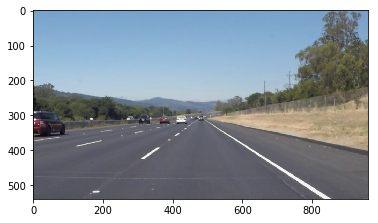

In [5]:
#reading in an image
image = plt.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image 

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
def plot_images(images, cmap=None, write=False, fileName="empty.png"):
    rows = (len(images)+1) // 2
    plt.figure(figsize=(10, 11))
    for i, img in enumerate(images):
        plt.subplot(rows, 2, i+1)
        plt.imshow(img, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
    if write:
        plt.savefig('./examples/plots/' + fileName)
    
    plt.show()

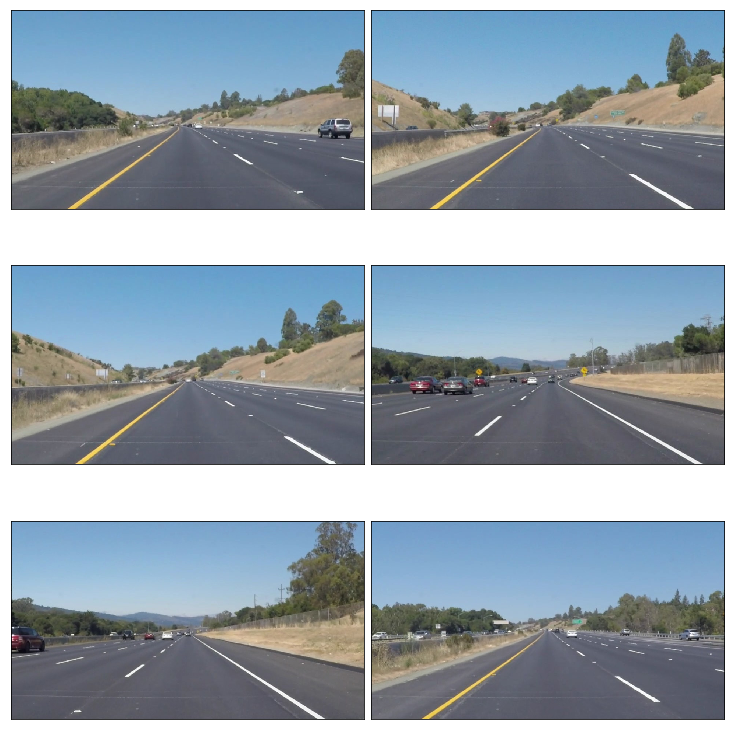

In [7]:
# loading test images
test_images = list()
for imgPath in os.listdir('./test_images/'):
    test_images.append(plt.imread('./test_images/'+imgPath))

plot_images(test_images)

In [8]:
def normalize_colors(img):
    # converting to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # define limits for white color in HSL
    lower = np.array([0, 200, 0]) 
    upper = np.array([255, 255, 255]) 
    
    # apply limits to HSL-image
    white = cv2.inRange(hls, lower, upper)
    
    # define limits for yellow color in HSL
    lower = np.array([10, 0, 100])
    upper = np.array([40, 255, 255])
    
    # apply limits to HSL-image
    yellow = cv2.inRange(hls, lower, upper)
    
    # combine to mask
    mask = cv2.bitwise_or(white, yellow)
    
    # apply mask to image
    normalized_image = cv2.bitwise_and(img, img, mask=mask)

    return normalized_image

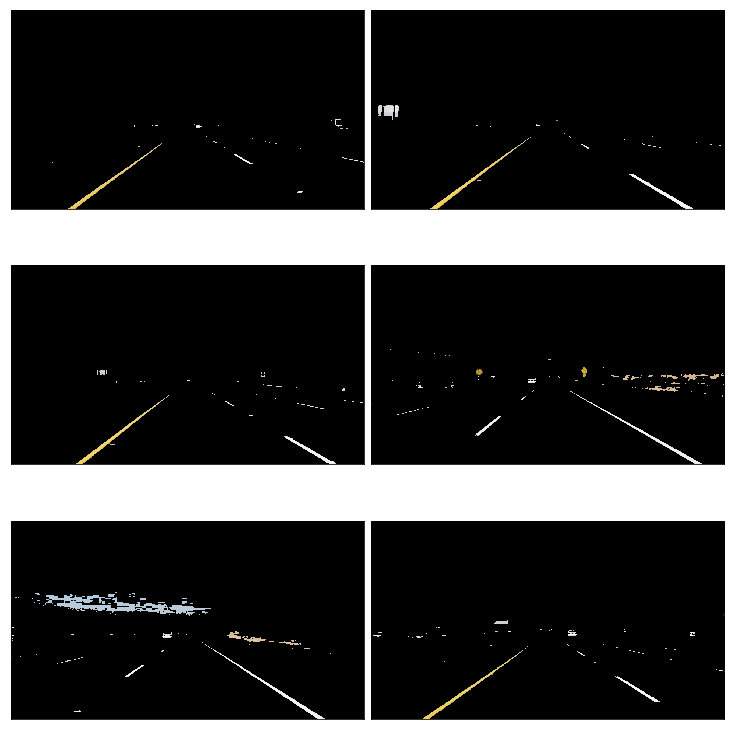

In [9]:
norm_images = list(map(normalize_colors, test_images))
plot_images(norm_images, write=True, fileName='filtered.png')

In [10]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

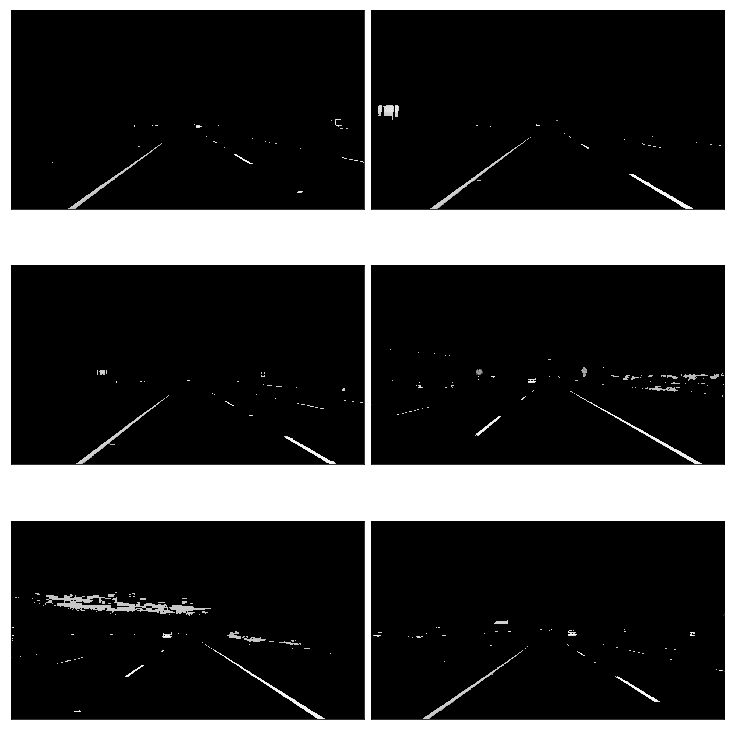

In [11]:
grayed = list(map(grayscale, norm_images))
plot_images(grayed, cmap='gray', write=True, fileName="grayscaled.png")

In [12]:
def gaussian_blur(img, kernel_size=11):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

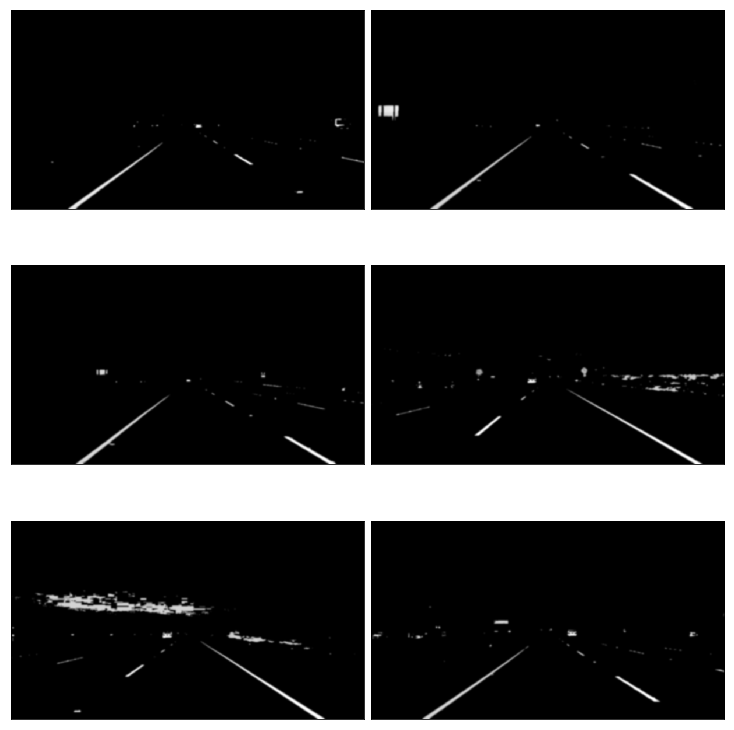

In [13]:
blurred = list(map(lambda gray: gaussian_blur(gray, 11), grayed))
plot_images(blurred, cmap='gray', write=True, fileName="gaussian_blur.png")

In [14]:
def auto_canny(image, σ=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - σ) * v))
    upper = int(min(255, (1.0 + σ) * v))
    auto = canny(image, lower, upper)
    return auto

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

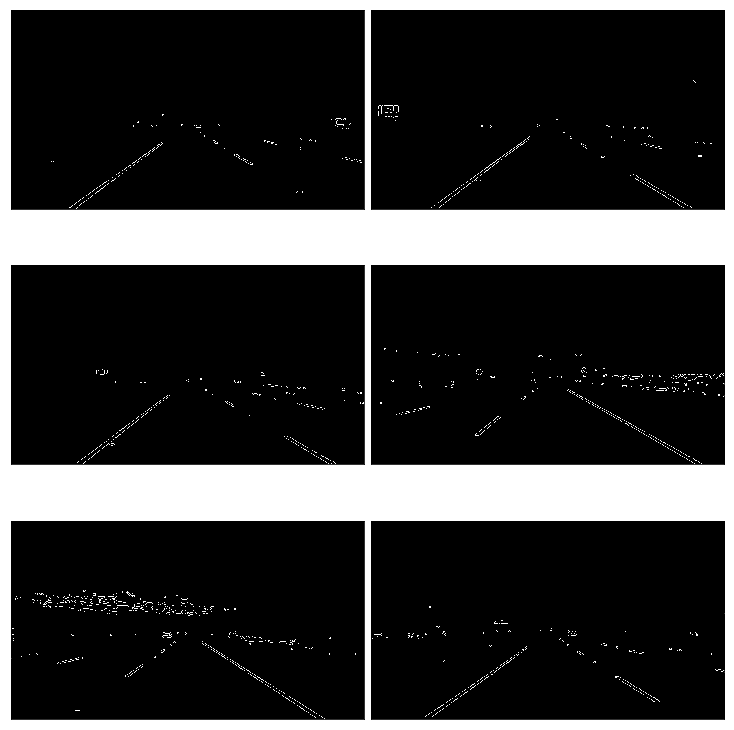

In [15]:
cannyed = list(map(lambda blur: auto_canny(blur), blurred))
plot_images(cannyed, cmap='gray', write=True, fileName='canny_edge.png')

In [16]:
top_y = np.array([])
def apply_roi(img, roi):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, roi, ignore_mask_color)
        
    return cv2.bitwise_and(img, mask)
    
def create_roi(img, default=True):
    global top_y
    
    ySize, xSize = img.shape[:2]
    if default:
        bLeft = [0, ySize]
        bRight = [xSize, ySize]
        tLeft = [(xSize*0.5)-20, (ySize*0.55)]
        tRight = [(xSize*0.5)+20, (ySize*0.55)]
    else:
        bLeft = [0, ySize]
        bRight = [xSize, ySize]
        tLeft = [(xSize*0.5)-25, top_y[-10:].mean()]
        tRight = [(xSize*0.5)+25, top_y[-10:].mean()]
    
    roi = np.array([[bLeft, bRight, tRight, tLeft]], dtype=np.int32)
    return roi
    
def create_and_apply_roi(img):
    roi = create_roi(img)
    return apply_roi(img, roi)

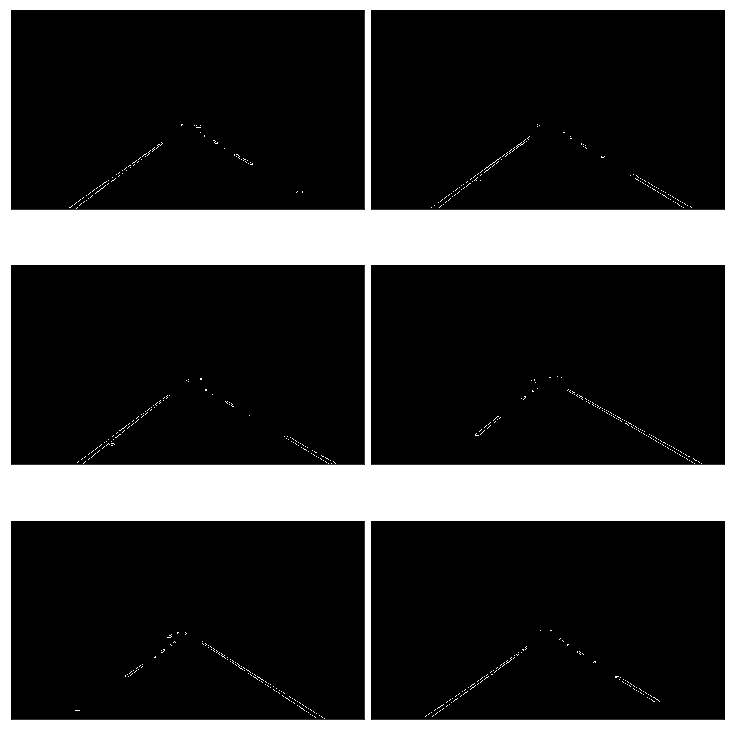

In [17]:
roi = list(map(create_and_apply_roi, cannyed))
plot_images(roi, cmap='gray')

In [18]:
def hough_lines(img, ρ=1, θ=(np.pi/180), threshold=5, min_line_len=10, max_line_gap=3):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, ρ, θ, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)    
    return lines

In [19]:
def draw_lines(img, lines, color=(255, 0, 0), thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    copy = np.copy(img)
    
    for line in lines:        
        for x1,y1,x2,y2 in line:
            cv2.line(copy, (x1, y1), (x2, y2), color, thickness)
    
    return copy

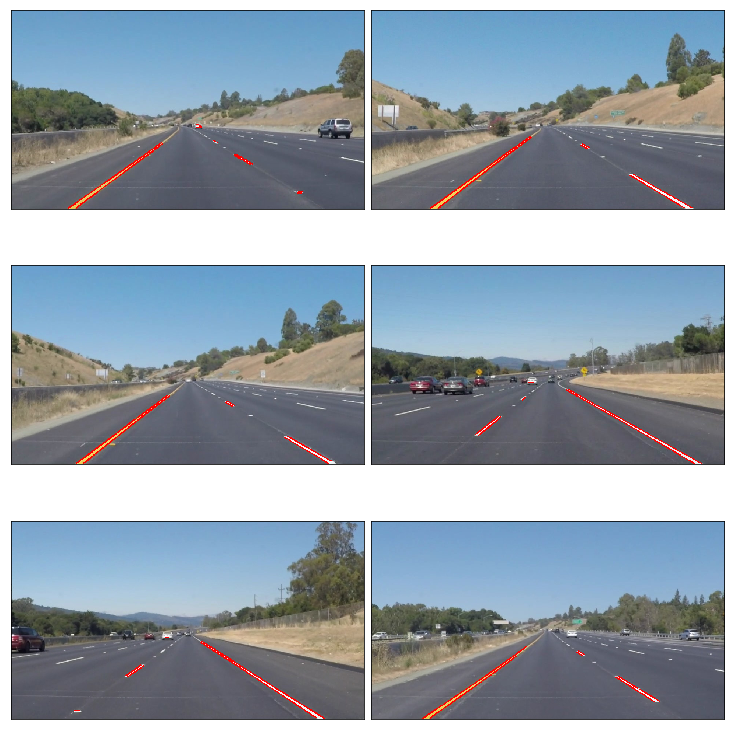

In [21]:
line_images = list()

for img, lines in zip(test_images, list(map(hough_lines, roi))):
    line_images.append(draw_lines(img, lines))
    
plot_images(line_images)

In [22]:
def lstsq_of(lines):
    global mean_left_m
    global mean_right_m
    global mean_left_b
    global mean_right_b
    global top_y
    
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1])/(row[2] - row[0]), 2, lines)
    
    # reversed!
    left_lines = lines[slopes < -0.25]
    right_lines = lines[slopes > 0.25]
    
    X = np.reshape(left_lines[:, [0,2]], (1, left_lines.shape[0] * 2))[0]
    Y = np.reshape(left_lines[:, [1,3]], (1, left_lines.shape[0] * 2))[0]
    A = np.vstack([X, np.ones(len(X))]).T

    m, b = np.linalg.lstsq(A, Y)[0]
    mean_left_m = np.append(mean_left_m, [m])
    mean_left_b = np.append(mean_left_b, [b])
    
    # averaged left lane
    left_lane = (mean_left_m[-10:].mean(), mean_left_b[-10:].mean())

    X = np.reshape(right_lines[:, [0,2]], (1, right_lines.shape[0] * 2))[0]
    Y = np.reshape(right_lines[:, [1,3]], (1, right_lines.shape[0] * 2))[0]
    A = np.vstack([X, np.ones(len(X))]).T
    
    m, b = np.linalg.lstsq(A, Y)[0]
    mean_right_m = np.append(mean_right_m, [m])
    mean_right_b = np.append(mean_right_b, [b])
    
    # averaged right lane
    right_lane = (mean_right_m[-15:].mean(), mean_right_b[-15:].mean())
    
    top_y = np.append(top_y, [np.min(left_lines), np.min(right_lines)])

    return left_lane, right_lane

In [23]:
def points_from_slope(y1, y2, line):
    m, b = line
    
    P = (int((y1-b)/m), int(y1))
    Q = (int((y2-b)/m), int(y2))
    
    return (P, Q)

In [35]:
def generate_lanes(img, lines):
    global top_y
    left_lane, right_lane = lstsq_of(lines)
    
    y1 = img.shape[0]
    y2 = np.max([y1 * 0.6, top_y[-10:].mean()])
    
    left_lane_points = points_from_slope(y1, y2, left_lane)
    right_lane_points = points_from_slope(y1, y2, right_lane)
    
    return left_lane_points, right_lane_points

In [25]:
# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [26]:
def draw_lanes(img, lines, color=(0,255,0), thickness=7):
    blank = np.zeros_like(img)

    for line in lines:
        cv2.line(blank, *line, color, thickness)
        color = (color[1],color[2],color[0])
        
    return blank

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

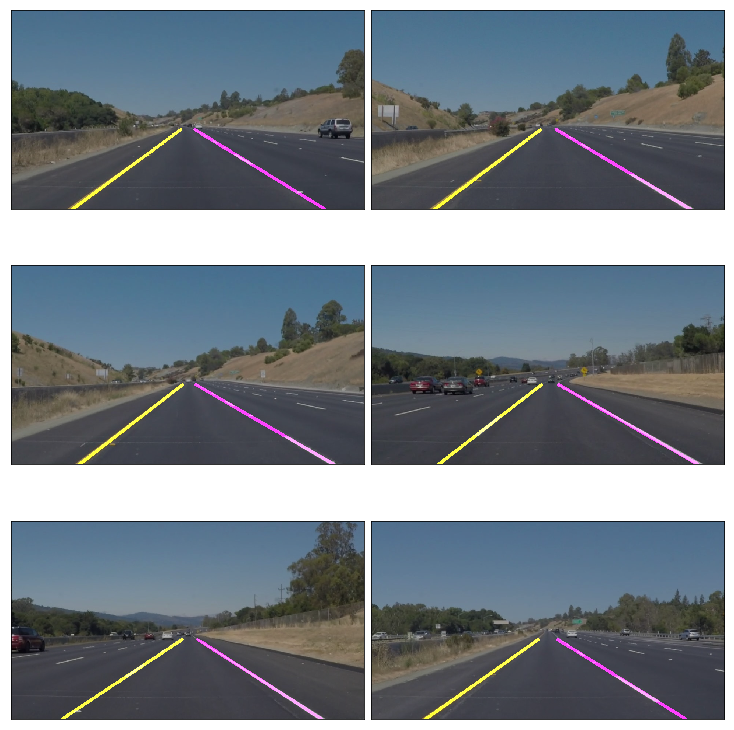

In [36]:
lane_images = list()
for _img, _lines in zip(test_images, list(map(hough_lines, roi))):
    mean_left_m = mean_right_m = mean_left_b = mean_right_b = top_y = np.array([])
    drawn_lanes = draw_lanes(_img, generate_lanes(_img, _lines), (255,255,0))
    drawn_lanes = apply_roi(drawn_lanes, create_roi(drawn_lanes, False))
    lane_images.append(weighted_img(_img, drawn_lanes, α=0.8, β=0.7))

plot_images(lane_images, cmap='gray', write=True, fileName='drawn_lanes.png')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [40]:
def process_image(image):
    normed = normalize_colors(image)
    grayed = grayscale(normed)
    smoothed = gaussian_blur(grayed)
    cannyed = auto_canny(smoothed)
    roi = create_and_apply_roi(cannyed)
    detected_lines = hough_lines(roi)

    drawn_lanes = draw_lines(image, detected_lines, (0,255,0), thickness=1)

    return weighted_img(image, drawn_lanes, α=0.1, β=0.8)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [41]:
mean_left_m = mean_right_m = mean_left_b = mean_right_b = top_y = np.array([])

white_output = os.path.join('examples', 'white.mp4')
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TypeError: 'float' object cannot be interpreted as an integer

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'white_output' is not defined

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [42]:
def pipeline_full(image):
    normed = normalize_colors(image)
    grayed = grayscale(normed)
    smoothed = gaussian_blur(grayed)
    cannyed = auto_canny(smoothed)
    roi = create_and_apply_roi(cannyed)
    detected_lines = hough_lines(roi)
    left_lane, right_lane = generate_lanes(image, detected_lines)

    drawn_lanes = draw_lanes(image, (left_lane, right_lane), (255,255,0))
    drawn_lanes_roi = create_roi(drawn_lanes, False)
    drawn_lanes = apply_roi(drawn_lanes, drawn_lanes_roi)

    return weighted_img(image, drawn_lanes, α=0.8, β=0.7)

In [43]:
def process_video(video_input, video_output):
    global mean_left_m
    global mean_right_m
    global mean_left_b
    global mean_right_b
    global top_y
    
    mean_left_m = mean_right_m = mean_left_b = mean_right_b = top_y = np.array([])

    clip = VideoFileClip(video_input)
    processed = clip.fl_image(pipeline_full)
    processed.write_videofile(os.path.join('examples', video_output), audio=False)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [44]:
yellow_output = 'yellow.mp4'
yellow_input = 'solidYellowLeft.mp4'
%time process_video(yellow_input, yellow_output)

TypeError: 'float' object cannot be interpreted as an integer

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./examples/' + yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [57]:
challenge_output = 'extra.mp4'
challenge_input = 'challenge.mp4'
%time process_video(challenge_input, challenge_output)

[MoviePy] >>>> Building video examples/extra.mp4
[MoviePy] Writing video examples/extra.mp4


100%|██████████| 251/251 [00:08<00:00, 28.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: examples/extra.mp4 

CPU times: user 9.81 s, sys: 248 ms, total: 10.1 s
Wall time: 9.64 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./examples/' + challenge_output))